# ***API MarketStack - Mariano Cruz***

# ***Librerías necesarias***

In [ ]:
!pip install deltalake matplotlib pandas requests

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.5/42.5 MB 13.9 MB/s eta 0:00:00


In [ ]:
import requests
import pandas as pd
from deltalake import write_deltalake, DeltaTable
from datetime import datetime
import matplotlib.pyplot as plt

# ***Clave API y rutas de almacenamiento***

In [ ]:
API_KEY = "7011745e6d312f7925679522a563f80c"
BASE_URL = "http://api.marketstack.com/v1/eod"

# Rutas locales
bronze_dir = "/content/bronze"  # Carpeta con datos crudos
processed_dir = "/content/processed"  # Carpeta con datos transformados

***Creo carpetas en Colab***

In [ ]:
import os
os.makedirs(bronze_dir, exist_ok=True)
os.makedirs(processed_dir, exist_ok=True)

# ***Extracción de datos de la API***

In [ ]:
def extract_full(symbol="AAPL"):
    """
    Realiza la extracción completa de datos desde la API de MarketStack.
    :param symbol: Símbolo de la acción (por ejemplo, 'AAPL' para Apple).
    :return: DataFrame con los datos extraídos.
    """
    try:
        params = {"access_key": API_KEY, "symbols": symbol, "limit": 100}
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()  # Verifica si la solicitud fue exitosa
        data = response.json()  # Convierte la respuesta a JSON
        if "data" in data:
            df = pd.DataFrame(data["data"])  # Crea un DataFrame
            df["Date"] = pd.to_datetime(df["date"])  # Convierte la columna de fechas
            return df
        else:
            print("No se encontraron datos en la API.")
            return pd.DataFrame()
    except Exception as e:
        print(f"Error en la extracción: {e}")
        return pd.DataFrame()

# ***Guardar datos en Delta Lake***

In [ ]:
def save_to_deltalake(df, path, mode="append"):
    """
    Guarda un DataFrame en formato Delta Lake.
    :param df: DataFrame a guardar.
    :param path: Ruta del directorio de almacenamiento.
    :param mode: Modo de almacenamiento ('append', 'overwrite').
    """
    try:
        write_deltalake(path, df, mode=mode)
        print(f"Datos guardados exitosamente en {path} en modo {mode}.")
    except Exception as e:
        print(f"Error al guardar en Delta Lake: {e}")

# ***Leer datos desde Delta Lake***

In [ ]:
def read_from_deltalake(path):
    """
    Lee un DataFrame desde Delta Lake.
    :param path: Ruta del directorio de almacenamiento.
    :return: DataFrame leído desde Delta Lake.
    """
    try:
        dt = DeltaTable(path)
        df = dt.to_pandas()
        print(f"Datos leídos desde {path}:")
        print(df.head())
        return df
    except Exception as e:
        print(f"Error al leer desde Delta Lake: {e}")
        return pd.DataFrame()

# ***Transformarción de los datos***

In [ ]:
def transform_data(df):
    """
    Transforma los datos aplicando varias operaciones:
    - Calcula el rendimiento diario.
    - Calcula un promedio móvil de 7 días.
    - Categoriza el rendimiento diario.
    - Filtra los datos para los últimos 30 días.
    """
    try:
        # Calcular el rendimiento diario
        df['daily_return'] = df['close'].pct_change()

        # Calcular promedio móvil de 7 días
        df['7_day_moving_avg'] = df['close'].rolling(window=7).mean()

        # Categorizar el rendimiento diario
        def categorize_return(value):
            if pd.isna(value):  # Manejar valores nulos
                return "Neutral"
            elif value > 0:
                return "Positive"
            elif value < 0:
                return "Negative"
            else:
                return "Neutral"
        df['return_category'] = df['daily_return'].apply(categorize_return)

        # Convertir las fechas a tz-naive (sin zona horaria)
        df['Date'] = pd.to_datetime(df['Date']).dt.tz_localize(None)

        # Filtrar los datos para los últimos 30 días
        df = df[df['Date'] > pd.Timestamp.now() - pd.Timedelta(days=30)]

        print("Datos transformados:")
        print(df.head())
        return df
    except Exception as e:
        print(f"Error en la transformación de datos: {e}")
        return pd.DataFrame()


# ***Visualización de datos***

In [ ]:
def visualize_data(df):
    """
    Visualiza el rendimiento diario en un gráfico de línea.
    :param df: DataFrame con los datos a visualizar.
    """
    if 'daily_return' in df.columns and not df.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['daily_return'], marker='o', linestyle='-', label="Rendimiento Diario")
        plt.title("Rendimiento Diario del Activo", fontsize=16)
        plt.xlabel("Fecha", fontsize=12)
        plt.ylabel("Rendimiento Diario (%)", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No hay datos para graficar.")

In [ ]:
# Función: Visualizar el rendimiento diario
def visualize_daily_return(df):
    """
    Visualiza el rendimiento diario en un gráfico de línea.
    """
    if 'daily_return' in df.columns and not df.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['daily_return'], marker='o', linestyle='-', label="Rendimiento Diario")
        plt.title("Rendimiento Diario del Activo", fontsize=16)
        plt.xlabel("Fecha", fontsize=12)
        plt.ylabel("Rendimiento Diario (%)", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No hay datos para graficar el rendimiento diario.")

# Función: Visualizar el promedio móvil de 7 días
def visualize_moving_avg(df):
    """
    Visualiza el promedio móvil de 7 días del precio de cierre en un gráfico de línea.
    """
    if '7_day_moving_avg' in df.columns and not df.empty:
        plt.figure(figsize=(12, 6))
        plt.plot(df['Date'], df['7_day_moving_avg'], marker='o', linestyle='-', label="Promedio Móvil de 7 días")
        plt.title("Promedio Móvil de 7 días del Precio de Cierre", fontsize=16)
        plt.xlabel("Fecha", fontsize=12)
        plt.ylabel("Promedio Móvil (USD)", fontsize=12)
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("No hay datos para graficar el promedio móvil.")

# Función: Visualizar las categorías del rendimiento diario
def visualize_return_categories(df):
    """
    Muestra una tabla con las categorías del rendimiento diario y la cantidad de días en cada categoría.
    """
    if 'return_category' in df.columns and not df.empty:
        category_counts = df['return_category'].value_counts()
        print("\nCantidad de días por categoría de rendimiento:")
        print(category_counts)

        # Gráfico de barras para las categorías
        category_counts.plot(kind='bar', figsize=(8, 6), color='skyblue', edgecolor='black')
        plt.title("Categorías del Rendimiento Diario", fontsize=16)
        plt.xlabel("Categoría", fontsize=12)
        plt.ylabel("Cantidad de días", fontsize=12)
        plt.xticks(rotation=0)
        plt.grid(axis='y')
        plt.show()
    else:
        print("No hay datos para graficar las categorías del rendimiento diario.")


Extracción de datos...
Datos guardados exitosamente en /content/bronze en modo overwrite.
Datos transformados:
     open      high     low    close      volume  adj_high  adj_low  \
0  246.89  247.7871  245.81  245.875  10087682.0       NaN      NaN   
1  241.83  247.2400  241.76  246.750  43606216.0    247.24   241.75   
2  242.91  244.6300  242.08  242.840  36852100.0    244.63   242.08   
3  243.99  244.5400  242.13  243.040  39961900.0    244.54   242.13   
4  242.88  244.1050  241.25  243.010  41848779.0    244.11   241.25   

   adj_close  adj_open  adj_volume  split_factor  dividend symbol exchange  \
0    245.875       NaN         NaN           1.0       0.0   AAPL     XNAS   
1    246.750   241.830  44649232.0           1.0       0.0   AAPL     XNAS   
2    242.840   242.905  36870619.0           1.0       0.0   AAPL     XNAS   
3    243.040   243.990  40033878.0           1.0       0.0   AAPL     XNAS   
4    243.010   242.870  44383935.0           1.0       0.0   AAPL     XN

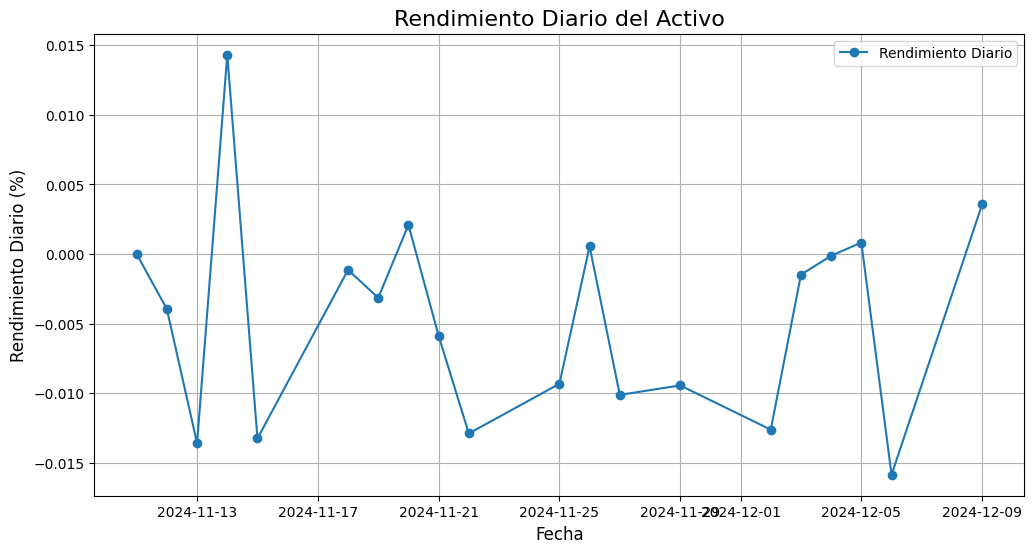


--- Visualización del Promedio Móvil de 7 días ---


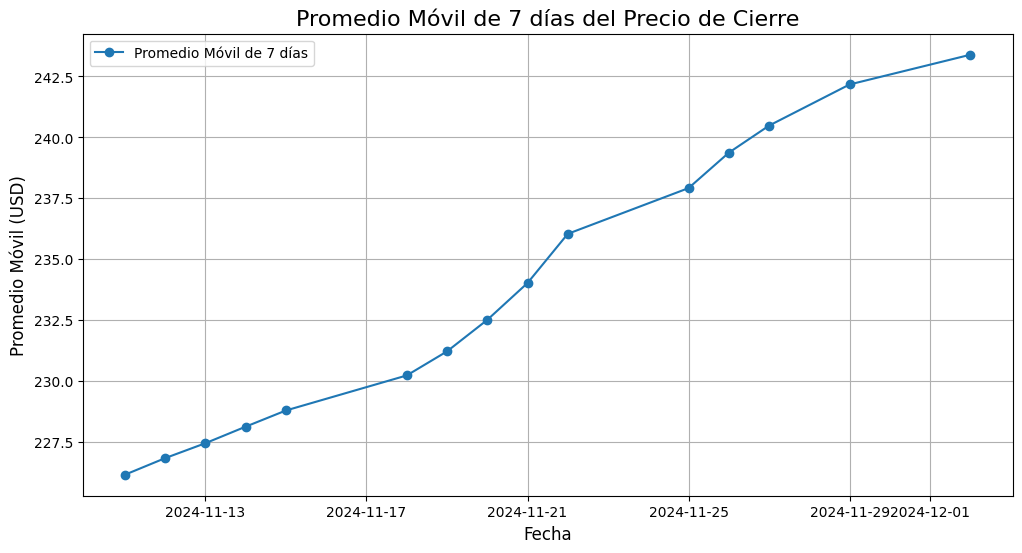


--- Visualización de Categorías del Rendimiento Diario ---

Cantidad de días por categoría de rendimiento:
return_category
Negative    14
Positive     5
Neutral      2
Name: count, dtype: int64


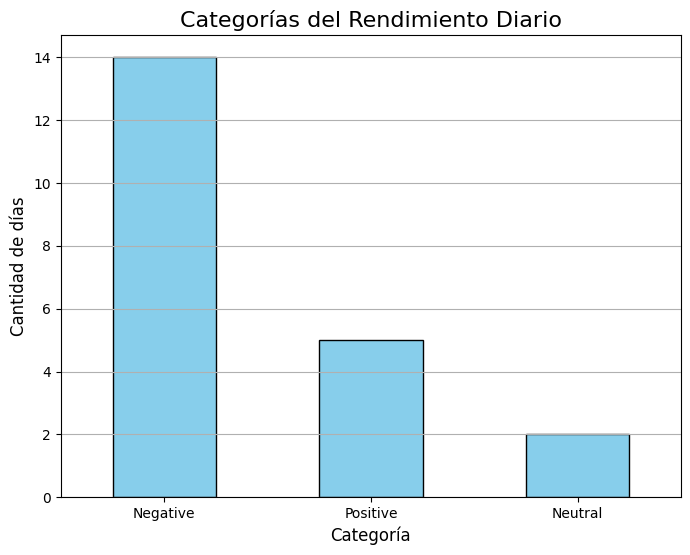

In [ ]:



# Flujo completo del código:

if __name__ == "__main__":
    # Extracción de datos
    print("Extracción de datos...")
    df = extract_full(symbol="AAPL")  # Cambia "AAPL" por el símbolo deseado
    if not df.empty:
        save_to_deltalake(df, bronze_dir, mode="overwrite")  # Guardar en capa bronze

        # Transformación de datos
        df_transformed = transform_data(df)
        if not df_transformed.empty:
            save_to_deltalake(df_transformed, processed_dir, mode="overwrite")  # Guardar en capa processed

            # Visualización de datos
            print("\n--- Visualización del Rendimiento Diario ---")
            visualize_daily_return(df_transformed)

            print("\n--- Visualización del Promedio Móvil de 7 días ---")
            visualize_moving_avg(df_transformed)

            print("\n--- Visualización de Categorías del Rendimiento Diario ---")
            visualize_return_categories(df_transformed)
        else:
            print("No se pudieron transformar los datos.")
    else:
        print("No se obtuvieron datos para extraer.")

